## Needfulls

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

### Load Dataset & Data Preparation

In [2]:
data = pd.read_csv("bike_sharing.csv", index_col = 0, parse_dates=True)
data.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


#### Duplicate Values

In [3]:
data.duplicated().sum()

21

There seems to be 21 duplicate values. Let us check them.

In [4]:
data[data.duplicated(keep=False)].head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-09 04:00:00,1,0,0,1,3.28,4.545,53,12.9980,0,1,1
2011-01-09 05:00:00,1,0,0,1,3.28,4.545,53,12.9980,0,1,1
2011-02-01 02:00:00,1,0,1,2,6.56,11.365,69,0.0000,0,2,2
2011-02-01 03:00:00,1,0,1,2,6.56,11.365,69,0.0000,0,2,2
2011-02-04 02:00:00,1,0,1,2,5.74,8.335,63,7.0015,0,1,1


Although above values could have been taken as duplicates, if you note carefully, the timestamp for each is different. In all the above cases, it simply implies that the condition from one hour to the next remained mostly the same. So, I am not removing any rows form the data.

#### Null Values

In [5]:
data.isna().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

No null values exist in the data.

#### Data Types

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


The data is for almost two years and is spaced for every hour.

##### Holiday vs Working Day
Holiday is marked 1, if it is a weekend or a holiday otherwise. Working day is marked 1, if it is not a holiday or weekend. Or we can say that working day is marked 0, whenever it is a holiday. Let us check if we have any observations that speak otherwise.

In [7]:
# It is not a holiday and it is not a working day - Weekends
print("Cross check: ", data[(data['holiday'] == 0) & (data['workingday'] == 0)].shape[0])
print("Number of weekends: ", data.index[(data.index.dayofweek == 5) | (data.index.dayofweek == 6)].shape[0])

# It is a holiday and it is a working day
print("Holiday & working: ", data[(data['holiday'] == 1) & (data['workingday'] == 1)].shape[0])

# Weekend + Holiday
weekend = data.loc[data.index[(data.index.dayofweek == 5) | (data.index.dayofweek == 6)]]
print("Weekend + Holiday: ", weekend[weekend['holiday'] == 1].shape[0])

Cross check:  3163
Number of weekends:  3163
Holiday & working:  0
Weekend + Holiday:  0


There are 3163 weekend hours. No weekends are working. No holidays have been classfied as weekends.
##### Weather & Season

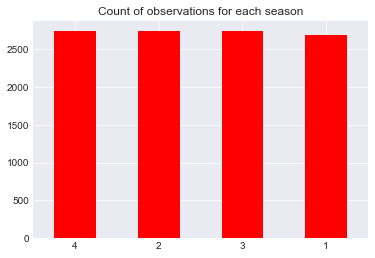

In [8]:
# Observations for each season
data["season"].value_counts().plot(kind='bar', rot=0, color='r', title="Count of observations for each season");

We have almost the equal number of observations for each type of season.

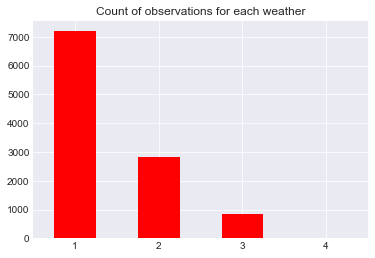

In [9]:
# Observations for each type of weather
data["weather"].value_counts().plot(kind='bar', rot=0, color='r', title="Count of observations for each weather");

Majority of the days have clear weather, followed by few clouds. Light and heavy rains are low in number.

##### Validating: Casual + Registered = Total

In [10]:
data[(~(data['casual'] + data['registered']) == data['count'])].shape

(0, 11)

Simple validation reveals, that the total count of users is equal to the number of casual users + registered users.

## Problem Statement

**The company wants to know:**

* Which variables are significant in predicting the demand for shared electric cycles in the Indian market?
* How well those variables describe the electric cycle demands?

**What We Can Do:**
From a preliminary analysis,
* Study the relationship between weather and count
* Go granular and study the relationship between each type of season for every weather wrt count. If there is anything significant, check if temperature, feeling temperature, humidity and windspeed bore any significance.
* Study the relationship between count and:
    * Holiday
    * Working day
    * Weekend

## Variable Exploration

#### Code

In [11]:
class BaseAnalysis:
    SEASON_MAP = {1: "Spring", 2: "Summer", 3: "Fall", 4: "Winter"}
    WEATHER_MAP = {1: "Clear", 2: "Cloudy", 3: "Light rain/snow", 4: "Heavy rain/snow"}
    
    def __init__(self, data, categorical_vars = None, continuous_vars = None, target_var = None):
        self.data = data
        self.categorical_vars = categorical_vars
        self.continuous_vars = continuous_vars
        self.target_var = target_var
        
        self._validation()
        
    def _validation(self):
        if self.target_var is not None:
            if not isinstance(self.target_var, list):
                raise TypeError(f"Variable target_var should be of type `list`. Passed value is of type {type(self.target_var)}")
                
        if self.categorical_vars is not None:
            if not isinstance(self.categorical_vars, list):
                raise TypeError(f"Variable categorical_vars should be of type `list`. Passed value is of type {type(self.categorical_vars)}")
                
        if self.continuous_vars is not None:
            if not isinstance(self.continuous_vars, list):
                raise TypeError(f"Variable continuous_vars should be of type `list`. Passed value is of type {type(self.continuous_vars)}")    
    
    def cat_data(self, annot=True):
        cat_data = self.data[self.categorical_vars + self.target_var]
        if annot:
            cat_data["weather"] = cat_data["weather"].map(BaseAnalysis.WEATHER_MAP)
            cat_data["season"] = cat_data["season"].map(BaseAnalysis.SEASON_MAP)
        return cat_data
    
    def cont_data(self):
        cont_data = self.data[self.continuous_vars + self.target_var]
        return cont_data

In [12]:
categorical_vars = ["season", "holiday", "workingday", "weather"]
continuous_vars = ["temp", "atemp", "humidity", "windspeed"]
target_var = ["casual", "registered", "count"]

uni_data = BaseAnalysis(data, categorical_vars, continuous_vars, target_var)

### Maximum Observations for Weather Type

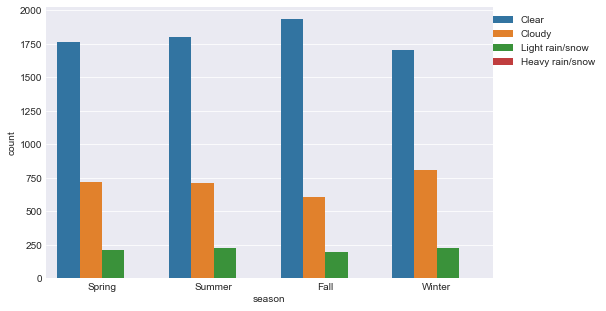

In [13]:
plt.figure(figsize=(8, 5))
sns.countplot(data = uni_data.cat_data(), x='season', hue='weather')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1));

Most of our observations and data is based on clear weather in various seasons. It is followed closely by cloudy weather. In terms of season, we have almost equal number of observations to study.

### Usage on Holidays vs Working Days vs Weekends

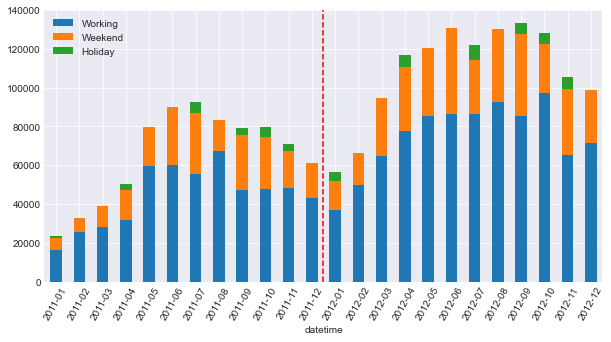

In [14]:
days_data = uni_data.cat_data().resample('D').sum()

# Weekend usage
weekend_usage = days_data.loc[days_data.index[(days_data.index.dayofweek == 5) | (days_data.index.dayofweek == 6)]]
weekend_usage_monthly = weekend_usage["count"].resample('M').sum()

# Holiday Usage
not_a_weekend = days_data.loc[days_data.index[(days_data.index.dayofweek != 5) & (days_data.index.dayofweek != 6)]]
holiday_usage = not_a_weekend[not_a_weekend["workingday"] == 0]
holiday_usage_monthly = holiday_usage["count"].resample('M').sum()

# Working Days
working_day_usage = not_a_weekend[not_a_weekend["workingday"] != 0]
working_day_usage_monthly = working_day_usage["count"].resample('M').sum()

# Check
assert(working_day_usage.shape[0] + holiday_usage.shape[0] + weekend_usage.shape[0] == days_data.shape[0])

# Combining
usage_day_wise = pd.DataFrame({
    "Working": working_day_usage_monthly,
    "Weekend": weekend_usage_monthly,
    "Holiday": holiday_usage_monthly
})

usage_day_wise.plot(kind= 'bar', stacked=True, figsize=(10, 5), grid=True, rot=60)
xticks = plt.xticks()[0]
xticklabels = [date.strftime('%Y-%m') for date in usage_day_wise.index]
plt.xticks(ticks = xticks, labels = xticklabels);
plt.axvline(x=11.5, ls='--', c='r');

**Observation:**
* Holidays usage takes a big hit in general. People are not going towards Yulu. 
* Working days have been the best.
* January to April have consistently performed poorer than other months.

### Relationship between Temperature, Humidity, Windspeed, Feelin Temp. & Usage

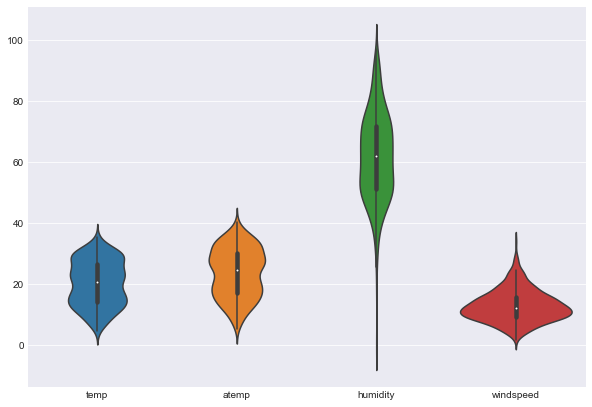

In [15]:
cont_data = uni_data.cont_data()
cont_data = cont_data.resample('D').agg({
    "temp": "mean",
    "atemp":"mean",
    "humidity":"mean",
    "windspeed":"mean",
    "casual":"sum",
    "registered":"sum",
    "count":"sum"
})

# Checking continuous variables
plt.figure(figsize=(10, 7))
sns.violinplot(data = cont_data.iloc[:, :4]);

* Temperature and feeling temperature are in almost a syc.
* Humidity is subject to extremes.
* Windspeed remains in a range with few extremes.

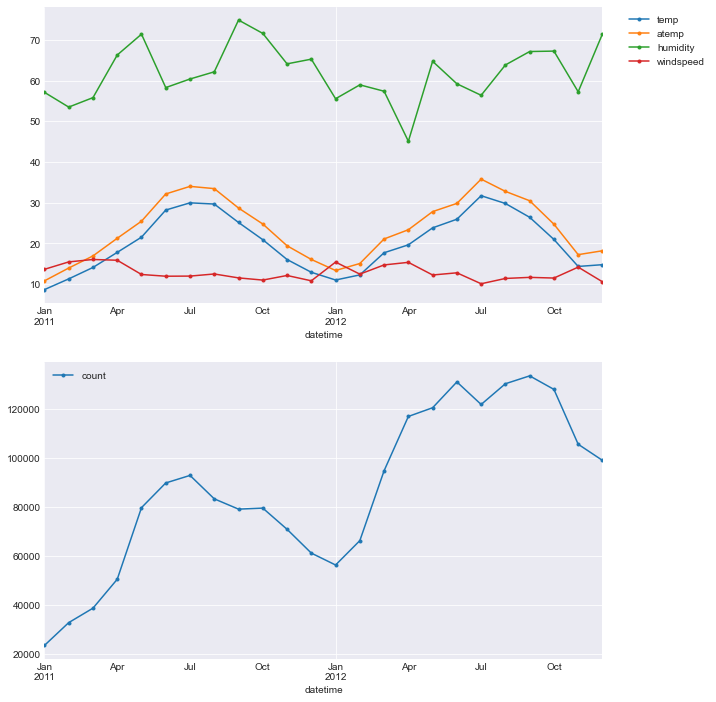

In [16]:
cont_monthly = cont_data.resample('M').agg({
    "temp": "mean",
    "atemp":"mean",
    "humidity":"mean",
    "windspeed":"mean",
    "casual":"sum",
    "registered":"sum",
    "count":"sum"
})

fig, ax = plt.subplots(2, 1)

cont_monthly.iloc[:, :4].plot(style='.-', figsize=(10, 12), ax = ax[0])
ax[0].legend(loc='upper right', bbox_to_anchor=(1.20, 1));

cont_monthly.iloc[:, 6:].plot(style='.-', figsize=(10, 12), ax=ax[1]);

There is a clear relationship between temperature and usage. As the temperature rises, usage rises and vice-versa.

### Count of Users for Each Weather & Season Type

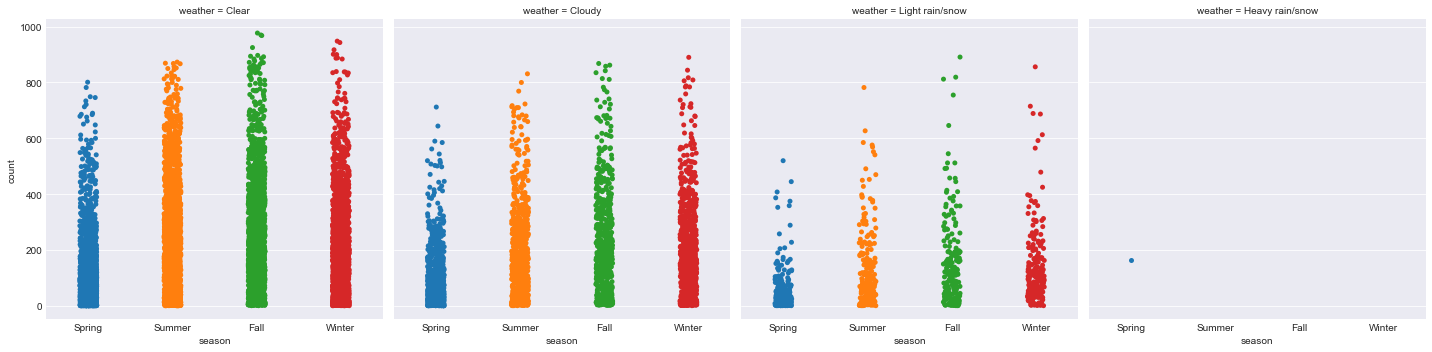

In [17]:
sns.catplot(data=uni_data.cat_data(), x = 'season', y = 'count', col='weather');

* Clear weather in the fall is a hit with the users. Clear weather in general shows good participation.
* Cloudy weather reduces participation - which is expected. Same pattern can be seen in light rain and snow.

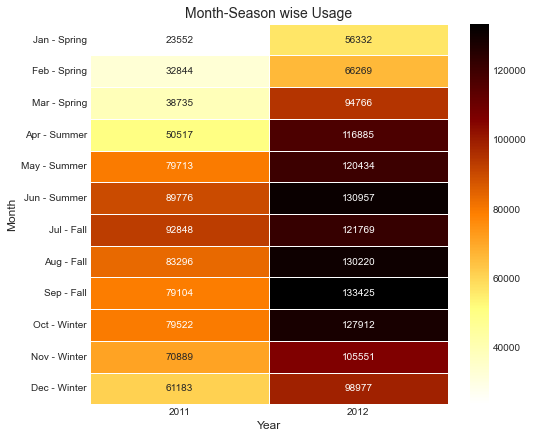

In [18]:
weather_type_by_year = uni_data.cat_data()
weather_type_by_year["year"] = weather_type_by_year.index.year
weather_type_by_year["month"] = weather_type_by_year.index.month
dict_season = weather_type_by_year[['month', 'season']].drop_duplicates().set_index('month').to_dict()['season']
updated_index = []
for k, v in dict_season.items():
    if (k==1):
        dict_season[k] = f"Jan - {dict_season[k]}"
    if (k==2):
        dict_season[k] = f"Feb - {dict_season[k]}"
    if (k==3):
        dict_season[k] = f"Mar - {dict_season[k]}"
    if (k==4):
        dict_season[k] = f"Apr - {dict_season[k]}"
    if (k==5):
        dict_season[k] = f"May - {dict_season[k]}"
    if (k==6):
        dict_season[k] = f"Jun - {dict_season[k]}"
    if (k==7):
        dict_season[k] = f"Jul - {dict_season[k]}"
    if (k==8):
        dict_season[k] = f"Aug - {dict_season[k]}"
    if (k==9):
        dict_season[k] = f"Sep - {dict_season[k]}"
    if (k==10):
        dict_season[k] = f"Oct - {dict_season[k]}"
    if (k==11):
        dict_season[k] = f"Nov - {dict_season[k]}"
    if (k==12):
        dict_season[k] = f"Dec - {dict_season[k]}"
        
weather_type_by_year["month_season"] = weather_type_by_year["month"].map(dict_season)
sns_df = weather_type_by_year.groupby(["year", "month"]).sum()[["count"]].unstack()["count"].T
sns_df.index = weather_type_by_year["month_season"].unique()
plt.figure(figsize=(8, 7))
ax = sns.heatmap(data=sns_df, cmap='afmhot_r', annot=True, fmt='d', linewidth=0.5)
ax.set_title("Month-Season wise Usage", fontsize=14)
ax.set_ylabel("Month", fontsize=12)
ax.set_xlabel("Year", fontsize=12);

* June to Novemeber for both years have been the most used months
* March of 2012 did see an increase.
* 2012 as a whole had seen more users than 2011.
* Summer and Fall seasons are much more active for Yulu.

### Conclusion
1. Working day vs Weekend - affects cycles rented
2. Clear and cloudy weathers see more usage (in general - weather affects cycyles rented)
3. Temperature affects cycles rented
4. Summer and Fall see more cycles rented (in general - season is affects cycles rented)

The above conclusions are based on purely on visual aid. Let us use some statistical tests to ensure we don't make unreasonable claims. We use only those business insights that are statisticall significant.

---

## Statistical Tests

### Working day vs Weekend affects Cycles Rented (t-test):
t-Test is being used because we are comparing two different groups of observations (working vs weekend) for the same thing (cycles rented).

**Assumtions to Check For:**
1. Sample independence
2. Normality of observations
3. Equal variance between two datasets
4. Random sampling

Levene's p-value: 0.0; Working vs Weekend SD: (131.68, 184.19)


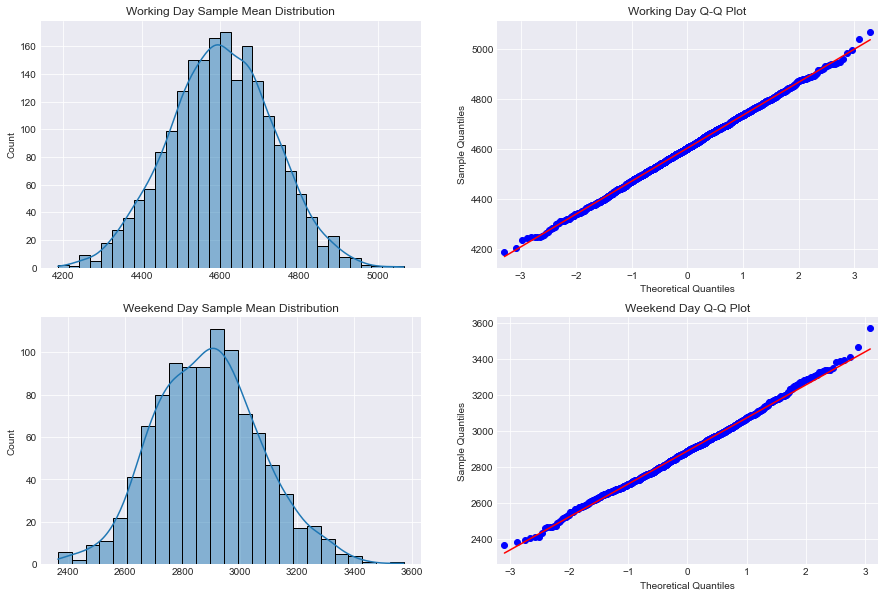

In [19]:
# Import the required test statistic
from scipy.stats import ttest_ind, levene
from scipy.stats import shapiro
import statsmodels.api as sm

# Working `count`
working_day_count = np.array([np.mean(np.random.choice(working_day_usage['count'].values, size=200)) for i in range(2000)])

# Weekend `count`
weekend_count = np.array([np.mean(np.random.choice(weekend_usage["count"].values, size=200)) for i in range(1000)])

# Assumptions Check
# Sample Independence
"""
Sample indedependence exists since we are picking two different day types; weekends and weekdays. The usage
over weekends cannot affect the usage over weekdays.
"""

# Normality
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

sm.qqplot(np.array(working_day_count), line='s', ax=ax[0][1])
ax[0][1].set_title("Working Day Q-Q Plot")
sns.histplot(working_day_count, kde=True, ax=ax[0][0])
ax[0][0].set_title("Working Day Sample Mean Distribution")

sm.qqplot(np.array(weekend_count), line='s', ax=ax[1][1])
ax[1][1].set_title("Weekend Day Q-Q Plot")
sns.histplot(weekend_count, kde=True, ax=ax[1][0])
ax[1][0].set_title("Weekend Day Sample Mean Distribution");

# Equal Variance
print(f"Levene's p-value: {round(levene(weekend_count, working_day_count, center='mean').pvalue, 4)}; Working vs Weekend SD: {round(working_day_count.std(), 2), round(weekend_count.std(), 2)}")

Clearly, both the distributions are normal distributed. Sampling is being done randomly and observations are independent. However, the assumption of equal variance is being violoated. We will neverthless apply the two-sided 2-sample t-Test to see the effect of difference in bicycles rented on working days vs weekends.

We will set `equal_var` to `False` so that the test used is Welch's t-Test, which doesn't assume equal variance.

**Hypothesis:**<br><br>
$ H_{0}: $ $\mu_{working} = \mu_{weekend} $ <br>
$ H_{1}: $ $\mu_{working} \neq \mu_{weekend} $


$\alpha = 0.05$

where, $\mu$ is the sample mean of cycles rented on workdays or weekends.



In [20]:
alpha = 0.05
p_val = ttest_ind(working_day_count, weekend_count, equal_var=False, axis=None).pvalue
if (p_val < alpha):
    print(f"{p_val}: We can reject the null hypothesis and safely say that there is significant difference between usage on weekends vs weekdays.")
    
"""
Let us check if on an average the weekend usage is more than the weekday usage.

In that case, 
the null hypothesis would change to: mean of working >= mean of weekend
the alternative hypothesis would change to: mean of working < mean of weekend.
"""
p_val = ttest_ind(working_day_count, weekend_count, equal_var=False, alternative='less').pvalue
if (p_val > alpha):
    print(f"{p_val}: We cannot reject the null hypothesis that working days see more or equal usage as compared to weekends.")

    
"""
Let us check if on an average the weekend usage is lesser than the weekday usage.

In that case, 
the null hypothesis would change to: mean of working <= mean of weekend
the alternative hypothesis would change to: mean of working > mean of weekend.
"""
p_val = ttest_ind(working_day_count, weekend_count, equal_var=False, alternative='greater').pvalue
if (p_val < alpha):
    print(f"{p_val}: We can reject the null hypothesis and say that working day usage is more than weekend usage.")

0.0: We can reject the null hypothesis and safely say that there is significant difference between usage on weekends vs weekdays.
1.0: We cannot reject the null hypothesis that working days see more or equal usage as compared to weekends.
0.0: We can reject the null hypothesis and say that working day usage is more than weekend usage.


From the 3 cases above, it is safe to say that working days see more usage as compared to weekends 95% of the time.

### Season affects Cycles Rented (ANOVA)
I will be using one-way ANOVA, since I have one independent variable `season` which can be divided into four parts - `Fall`, `Spring`, `Summer`, `Winter`.

**Assumtions to Check For:**
1. Sample independence
2. Normality of observations
3. Equal variance between two datasets
4. Random sampling

Levene's p-value: 0.0
Fall SD: 14.35; Fall Mean: 234.6
Summer SD: 13.52; Summer Mean: 215.17
Winter SD: 12.43; Winter Mean: 198.99
Spring SD: 8.86; Spring Mean: 116.46


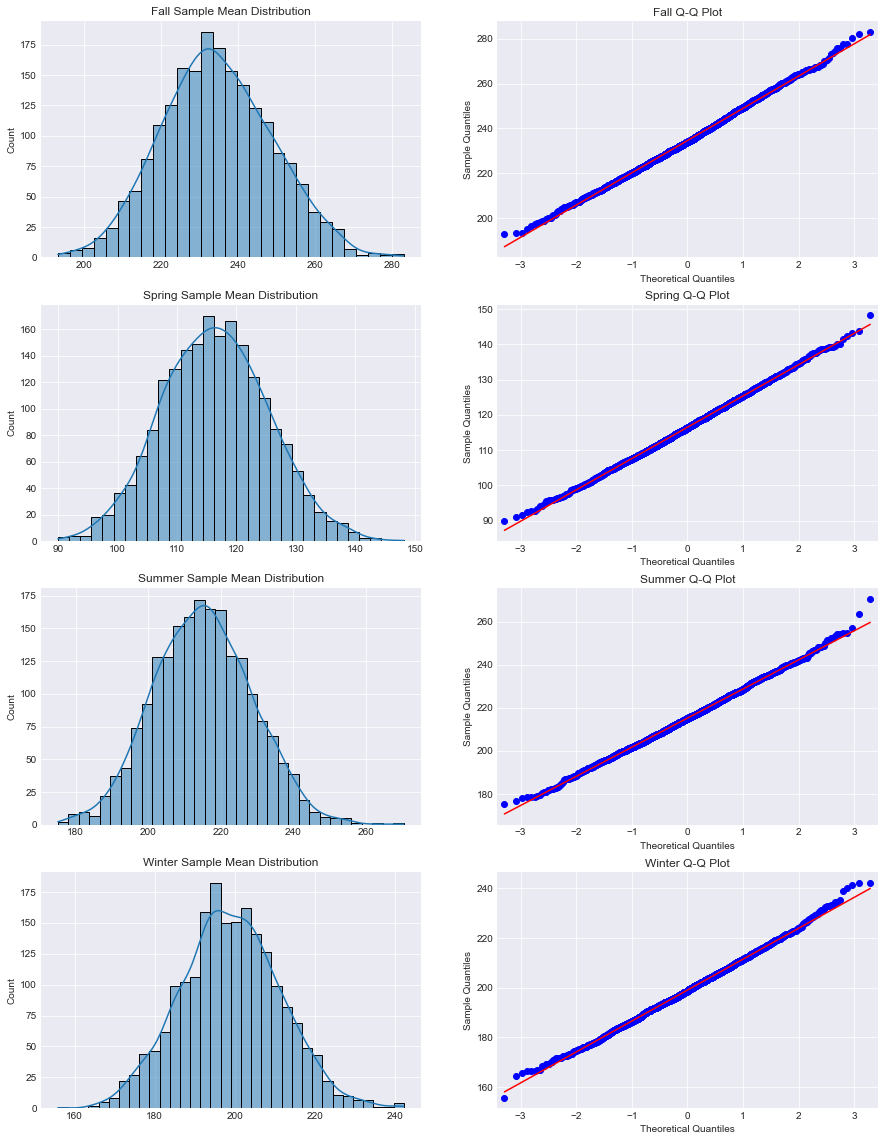

In [21]:
from scipy.stats import shapiro, f_oneway
import statsmodels.api as sm

season_obj = weather_type_by_year.groupby("season")

# `count` for seasons
fall = np.array([np.mean(np.random.choice(season_obj.get_group("Fall")["count"].values, size=200)) for i in range(2000)]) 
spring = np.array([np.mean(np.random.choice(season_obj.get_group("Spring")["count"].values, size=200)) for i in range(2000)])
summer = np.array([np.mean(np.random.choice(season_obj.get_group("Summer")["count"].values, size=200)) for i in range(2000)])
winter = np.array([np.mean(np.random.choice(season_obj.get_group("Winter")["count"].values, size=200)) for i in range(2000)])

# Assumptions Check
# Sample Independence
"""
Sample indedependence exists since we are randomly selecting 200 values for each season from two different years.
"""

# Normality
fig, ax = plt.subplots(4, 2, figsize=(15, 20))

sm.qqplot(np.array(fall), line='s', ax=ax[0][1])
ax[0][1].set_title("Fall Q-Q Plot")
sns.histplot(fall, kde=True, ax=ax[0][0])
ax[0][0].set_title("Fall Sample Mean Distribution")

sm.qqplot(np.array(spring), line='s', ax=ax[1][1])
ax[1][1].set_title("Spring Q-Q Plot")
sns.histplot(spring, kde=True, ax=ax[1][0])
ax[1][0].set_title("Spring Sample Mean Distribution");

sm.qqplot(np.array(summer), line='s', ax=ax[2][1])
ax[2][1].set_title("Summer Q-Q Plot")
sns.histplot(summer, kde=True, ax=ax[2][0])
ax[2][0].set_title("Summer Sample Mean Distribution");

sm.qqplot(np.array(winter), line='s', ax=ax[3][1])
ax[3][1].set_title("Winter Q-Q Plot")
sns.histplot(winter, kde=True, ax=ax[3][0])
ax[3][0].set_title("Winter Sample Mean Distribution");


# Equal Variance
print(f"Levene's p-value: {round(levene(fall, spring, summer, winter, center='mean').pvalue, 4)}")
print(f"Fall SD: {round(fall.std(), 2)}; Fall Mean: {round(fall.mean(), 2)}")
print(f"Summer SD: {round(summer.std(), 2)}; Summer Mean: {round(summer.mean(), 2)}")
print(f"Winter SD: {round(winter.std(), 2)}; Winter Mean: {round(winter.mean(), 2)}")
print(f"Spring SD: {round(spring.std(), 2)}; Spring Mean: {round(spring.mean(), 2)}")

Clearly, the distributions are normally distributed. Sampling is being done randomly and observations are independent. However, the assumption of equal variance is being violated. We will neverthless apply the one-way ANOVA test.

We could ideally use, `Kruskal-Wallis H-test (scipy.stats.kruskal)` or the `Alexander-Govern test (scipy.stats.alexandergovern)` although with some loss of power, as per `scipy.stats` documentation.

**Hypothesis:**<br><br>
$ H_{0}: $ $ \mu_{spring} = \mu_{winter} = \mu_{fall} = \mu_{summer} $ <br>
$ H_{1}: $ $ \mu_{spring} \neq \mu_{winter} \neq \mu_{fall} \neq \mu_{summer} $


$\alpha = 0.05$

where, $\mu$ is the sample mean of the cycles rented as per season.

In [22]:
alpha = 0.05
p_val = f_oneway(summer, winter, spring, fall).pvalue

if (p_val < alpha):
    print("We can reject the null hypothesis and safely conclude that there is a significant difference between the cycles rented as per season.")

We can reject the null hypothesis and safely conclude that there is a significant difference between the cycles rented as per season.


One could use:
1. Bonferroni approach
2. Least significant difference test
3. Tukey's HSD

to see which season is causing a significant difference. However, it is currently out of scope for this case study.

From the levene's test outcomes, we can see that Winter and Spring cause significant differences in cycles rented (on the lower side).

### Weather affects Cycles Rented (ANOVA)
I will be using one-way ANOVA, since I have one independent variable `weather` which can be divided into four parts - `Clear`, `Cloudy`, `Light rain/snow`, `Heavy rain/snow`.

However, the observations for `Heavy rain/snow` are just 164 in number (based on hourly data). Therefore, I wouldn't be considering this class for the analysis.

**Assumtions to Check For:**
1. Sample independence
2. Normality of observations
3. Equal variance between two datasets
4. Random sampling

Levene's p-value: 0.0
Clear SD: 14.35; Clear Mean: 234.6
Cloudy SD: 13.52; Cloudy Mean: 215.17
Light Rain/Snow SD: 12.43; Light Rain/Snow Mean: 198.99


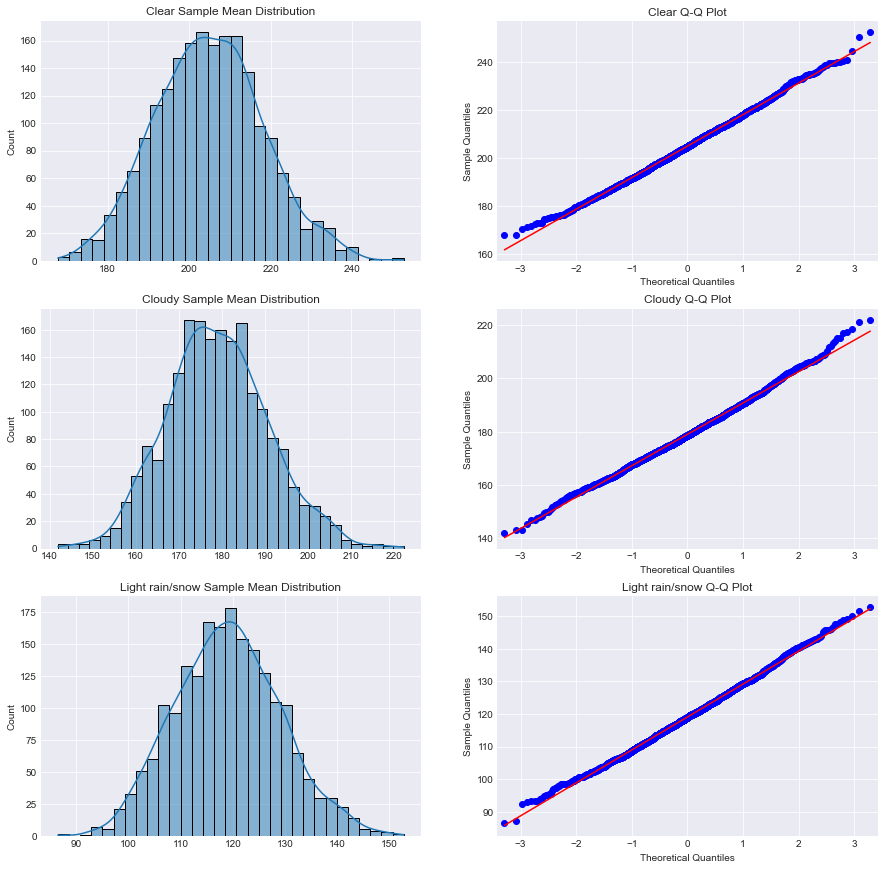

In [23]:
from scipy.stats import shapiro, f_oneway
import statsmodels.api as sm

season_obj = weather_type_by_year.groupby("season")

# `count` for weather
clear = np.array([np.mean(np.random.choice(uni_data.cat_data().groupby("weather")["count"].get_group("Clear").values, size=200)) for i in range(2000)]) 
cloudy = np.array([np.mean(np.random.choice(uni_data.cat_data().groupby("weather")["count"].get_group("Cloudy").values, size=200)) for i in range(2000)])
light_rain = np.array([np.mean(np.random.choice(uni_data.cat_data().groupby("weather")["count"].get_group("Light rain/snow").values, size=200)) for i in range(2000)])

# Assumptions Check
# Sample Independence
"""
Sample indedependence exists since we are randomly selecting 200 values for each season from two different years.
"""

# Normality
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

sm.qqplot(np.array(clear), line='s', ax=ax[0][1])
ax[0][1].set_title("Clear Q-Q Plot")
sns.histplot(clear, kde=True, ax=ax[0][0])
ax[0][0].set_title("Clear Sample Mean Distribution")

sm.qqplot(np.array(cloudy), line='s', ax=ax[1][1])
ax[1][1].set_title("Cloudy Q-Q Plot")
sns.histplot(cloudy, kde=True, ax=ax[1][0])
ax[1][0].set_title("Cloudy Sample Mean Distribution");

sm.qqplot(np.array(light_rain), line='s', ax=ax[2][1])
ax[2][1].set_title("Light rain/snow Q-Q Plot")
sns.histplot(light_rain, kde=True, ax=ax[2][0])
ax[2][0].set_title("Light rain/snow Sample Mean Distribution");


# Equal Variance
print(f"Levene's p-value: {round(levene(clear, cloudy, light_rain, center='mean').pvalue, 4)}")
print(f"Clear SD: {round(fall.std(), 2)}; Clear Mean: {round(fall.mean(), 2)}")
print(f"Cloudy SD: {round(summer.std(), 2)}; Cloudy Mean: {round(summer.mean(), 2)}")
print(f"Light Rain/Snow SD: {round(winter.std(), 2)}; Light Rain/Snow Mean: {round(winter.mean(), 2)}")

Clearly, the distributions are normally distributed. Sampling is being done randomly and observations are independent. However, the assumption of equal variance is being violated. We will neverthless apply the one-way ANOVA test.

We could ideally use, `Kruskal-Wallis H-test (scipy.stats.kruskal)` or the `Alexander-Govern test (scipy.stats.alexandergovern)` although with some loss of power, as per `scipy.stats` documentation.

**Hypothesis:**<br><br>
$ H_{0}: $ $ \mu_{clear} = \mu_{cloudy} = \mu_{lightRain} $ <br>
$ H_{1}: $ $ \mu_{clear} \neq \mu_{cloudy} \neq \mu_{lightRain} $


$\alpha = 0.05$

where, $\mu$ is the sample mean of the cycles rented as per weather.

In [24]:
alpha = 0.05
p_val = f_oneway(clear, cloudy, light_rain).pvalue

if (p_val < alpha):
    print("We can reject the null hypothesis and safely conclude that there is a significant difference between the cycles rented as per weather.")

We can reject the null hypothesis and safely conclude that there is a significant difference between the cycles rented as per weather.


One could use:
1. Bonferroni approach
2. Least significant difference test
3. Tukey's HSD

to see which weather is causing a significant difference. However, it is currently out of scope for this case study.

From the levene's test outcomes, we can see that light rain cause significant differences in cycles rented (on the lower side).

### Dependence of Weather on Season (Chi-square test)

**Hypothesis:**<br><br>
$ H_{0}: $ Weather and Season are independent <br>
$ H_{1}: $ Weather and season are dependent

$\alpha = 0.05$


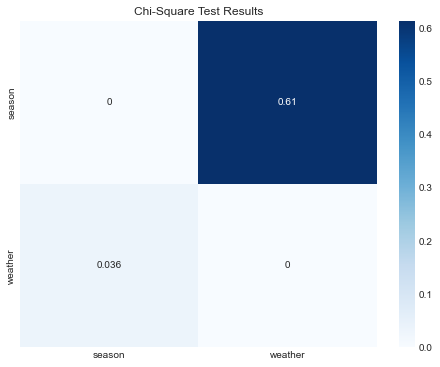

In [25]:
from sklearn.feature_selection import chi2

data_for_weather_season = data[["season", "weather"]]
df = data_for_weather_season
resultant = pd.DataFrame(data=[(0 for i in range(len(df.columns))) for i in range(len(df.columns))], 
                         columns=list(df.columns))
resultant.set_index(pd.Index(list(df.columns)), inplace = True)

# Finding p_value for all columns and putting them in the resultant matrix
for i in list(df.columns):
    for j in list(df.columns):
        if i != j:
            chi2_val, p_val = chi2(np.array(df[i]).reshape(-1, 1), np.array(df[j]).reshape(-1, 1))
            resultant.loc[i,j] = p_val

# Plotting a heatmap
fig = plt.figure(figsize=(8,6))
sns.heatmap(resultant, annot=True, cmap='Blues')
plt.title('Chi-Square Test Results')
plt.show()

We can easily conclude from the above matrix that weather is dependent on season since it has a p-value of 0.036 (< 0.05). The reverse is clearly not true.

## Actionables

1. **Working days usage is much higher than weekend usage. Holiday usage is very low.**
    * This implies that many users of the product are office goers. The company should capitalise on this by reducing rates and increasing capacity. 
    * Weekends are popular but not as much as workdays. 
        * **This could be due to:**
            1. Lack of product awareness among non-office goers.
            2. Regular users preffering other modes of transport on weekend.
            3. Weekend places like party areas not having Yulu facility.
            
        * **To Do:**
            1. Organise weekend engagement activities.
            2. Check the popular age groups that use the facility, map their behaviour on weekends and provide the option of Yulu at the frequented areas. For instance, the night market outside of a pub for leisure rides among late 20s to early 40s can be a popular market.
            3. Check **why** people are using the product: last-mile travel, leisure, fitness, ease-of-use. Promote the lifestyle **why** by organising community engangement activities.

2. **Weather has a major effect.**
    1. Clear and cloudy weather see good usage. In case there is capacity underutilisation, add more bikes. The areas on where to increase capacity can be taken from point 1.
    2. Light rain does see some participation. Things that can be done for increasing this share:
        * Create covered tracks in popular regions and market the product for a day outdoor in the rain
        * Explore cost effective rain shields for the bikes.
3. **Season has a major effect.**
    * Summer and Fall see considerable usage. In that, clear and cloudy weathers are clear winners.
    * Conduct a survey to understand what do people prefer in winters. Based on the survey, explore product enhancements like air shields and seat warmers.
    * Need to understand market for spring for a good business decision.
    
Since the business is dependent to a large extent on weather and season, the cyclic nature of the business needs to be broken to permeate it across the year. Moreover, market expansion and research as highlighted in point 1 needs to be done for a sustainable market.